# SFXLearner

This notebook is used for demonstrating the workflow of the paper "Automatic Recognition of Cascaded Guitar Effects" at DAFX23.

In [27]:
# library imports
import os
import tqdm
import torch
import sklearn
import mirdata.datasets.guitarset
import pytorch_lightning as pl
import matplotlib.pyplot as plt

# internal imports
from src.model.pl_wrapper import LightningWrapper
from src.model.resnet import resnet18
from src.dataloader import MultiFXDataset
from src.generate_data import (
    slice_guitarset,
    slice_idmt_smt_guitar,
    generate_dataset_sox,
)

### Data Preprocessing
You can skip this step and jump to `Effect Processing` if you only want to have a demo run over the provided `guitarset10` subset.

Here we download the clean guitar datasets, and slice them into 5-second clips.
#### GuitarSet


In [3]:
# Change to your desired path
guitarset_path = "../raw_dataset/GuitarSet/"
guitarset_path_sliced = "../dataset/clean/GuitarSet"

guitarset = mirdata.datasets.guitarset.Dataset(data_home=guitarset_path)
print(guitarset.readme())
print(guitarset.cite())
guitarset.download(partial_download=["audio_mic"])

INFO: Downloading ['audio_mic'] to ../raw_dataset/GuitarSet/
INFO: [audio_mic] downloading audio_mono-mic.zip
626MB [02:26, 4.49MB/s]                               


In [5]:
# slice guitarset into 5s clips
guitarset_path_sliced = slice_guitarset(
    guitarset_path, save_dir=guitarset_path_sliced, duration=5
)

100%|██████████| 360/360 [03:05<00:00,  1.94it/s]

Generation complete! 2004 audio files is generated to ../dataset/GuitarSet/guitarset_5.0s_clean.


#### IDMT-SMT-GUITAR

Please download `IDMT-SMT-Guitar` and unzip manually: https://zenodo.org/record/7544110


In [2]:
# Change to your desired path
idmt_path = "../raw_dataset/IDMT-SMT-GUITAR_V2"
idmt_path_sliced = "../dataset/clean/IDMT-SMT-GUITAR"

idmt_path_sliced = slice_idmt_smt_guitar(
    data_home=idmt_path, save_dir=idmt_path_sliced, duration=5
)

100%|██████████| 507/507 [03:52<00:00,  2.18it/s]

Generation complete! 2382 audio files is generated to ../dataset/IDMT-SMT-GUITAR/IDMT-SMT-GUITAR_5s.


### Effect Processing

Kind reminder: generating the full dataset will take several hours for each dataset.

Here we run the generation over a small subset with only 10 clean samples.

A `settings.yml` file will be generated in the output folder, recording the generation parameters.

In [4]:
# change this to the paths of the full dataset to run the full experiment 
guitarset10_path = "dataset/clean/guitarset10"

In [3]:
guitarset_path_rendered = "dataset/generated/guitarset10"
generate_dataset_sox([guitarset10_path], guitarset_path_rendered, methods=[1, 5], valid_split=0.2)

=> Generating FX dataset...
=> Using default fx params and grouping
=> Settings:
{'fx_chain_type': 'multi',
 'fx_grouping': [(0, 1), (2, 3, 4, 5), (6,), (7, 8), (9, 10), (11, 12)],
 'fx_params': OrderedDict([('overdrive', {'gain_db': 5}),
                           ('distortion', {'gain_db': 15}),
                           ('chorus', {'n_voices': 5}),
                           ('flanger', {'depth': 5, 'phase': 50}),
                           ('phaser', {}),
                           ('tremolo', {}),
                           ('reverb', {'reverberance': 80}),
                           ('feedback_delay',
                            {'decays': [0.4, 0.2, 0.1],
                             'delays': [200, 400, 600],
                             'gain_out': 0.5,
                             'n_echos': 3}),
                           ('slapback_delay',
                            {'decays': [0.4, 0.2, 0.1],
                             'delays': [200, 400, 600],
                       

sample count: 100%|██████████| 6/6 [01:50<00:00, 18.47s/it]


=> Generating valid set from dataset/clean/guitarset10


sample count: 100%|██████████| 4/4 [01:16<00:00, 19.01s/it]


=> Generated 1326 samples to dataset/generated/guitarset10/gen_multiFX_05252023/train
=> Generated 884 samples to dataset/generated/guitarset10/gen_multiFX_05252023/valid
=> Training set labels written to dataset/generated/guitarset10/gen_multiFX_05252023/train/label_tensor.pt
=> Validation set labels written to dataset/generated/guitarset10/gen_multiFX_05252023/valid/label_tensor.pt
=> Training link file written to dataset/generated/guitarset10/gen_multiFX_05252023/train/clean_link.csv
=> Validation link file written to dataset/generated/guitarset10/gen_multiFX_05252023/valid/clean_link.csv
=> settings written to dataset/generated/guitarset10/gen_multiFX_05252023/settings.yml
=> Done!


### Model training

In [9]:
!python src/train_multiFX.py \
        resnet18 \
        dataset/generated/guitarset10/gen_multiFX_05252023 \
        --max_epoch 10 \
        --gpus 1 \
        --batch_size 16 \
        --val_check_interval 0.5 \
        --random_seed 42 \
        --log_class_loss true \
        --with_clean true

Global seed set to 42
=> Start training
=> Training with clean
/home/jinyueg/miniconda3/envs/sfx_learner/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/jinyueg/felles/Research/Users/jinyueg/DAFX23/SFXlearner/lightning_logs/multiFX_resnet18_[1,5]_with_clean
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | resnet18                  | 714 K 
1 | transform | MelSpectrogramDBTransform | 0     
--------------------------------------------------------
714 K     Tr

### Model evaluation

In [10]:
from src.transforms import MelSpectrogramDBTransform
from src.model.resnet import resnet18
from src.model.pl_wrapper import LightningWrapper

In [16]:
# load trained model

model = LightningWrapper.load_from_checkpoint(
    checkpoint_path="lightning_logs/multiFX_resnet18_[1,5]_with_clean/version_0/checkpoints/epoch=4-step=373.ckpt",
    model=resnet18(in_channels=2, num_classes=13),
    with_clean=True,
    lr=1e-3,
    transform=MelSpectrogramDBTransform(),
)
model.eval()

LightningWrapper(
  (model): resnet18(
    (conv1): Conv2d(2, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=(1, 2), padding=1, dilation=1, ceil_mode=False)
    (layer_1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_run

In [19]:
# load validation set
valid_set = MultiFXDataset("dataset/generated/guitarset10/gen_multiFX_05252023", "valid", None)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, num_workers=2)
classes = list(valid_set.settings["fx_params"].keys())

In [23]:
# run inference

model.cuda()
y = torch.randn(1, 13, requires_grad=False).cuda()
y_hat = torch.randn(1, 13, requires_grad=False).cuda()
with torch.no_grad():
    for batch in tqdm.tqdm(valid_loader):
        x, y_batch = batch
        y_hat_batch = model(x.cuda())
        y = torch.vstack([y, y_batch.cuda()])
        y_hat = torch.vstack([y_hat, y_hat_batch.cuda()])
        del x, y_batch, y_hat_batch
        torch.cuda.empty_cache()
y_hat = torch.sigmoid(y_hat) > 0.5

100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


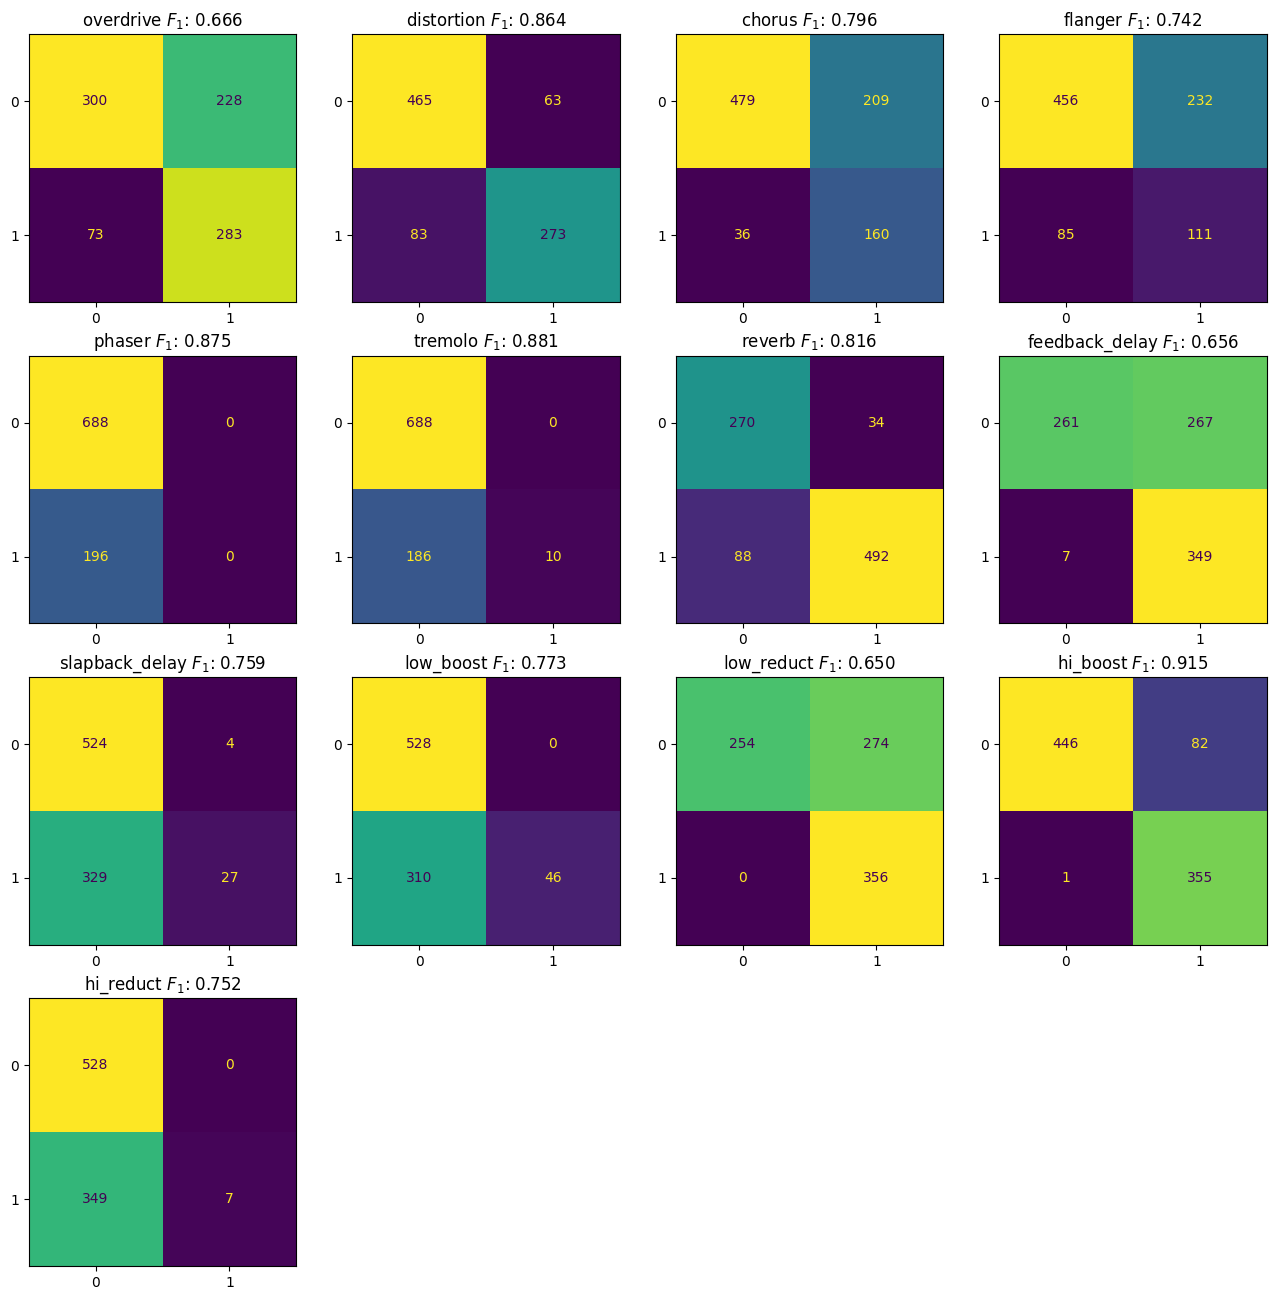

In [45]:
# generate per-class confusion matrix

fig, ax = plt.subplots(4, 4)
fig.set_size_inches(16, 16)
cms = sklearn.metrics.multilabel_confusion_matrix(
    y[1:].cpu().to(torch.int), y_hat[1:].cpu().to(torch.int)
)
for i in range(len(classes)):
    disp = sklearn.metrics.ConfusionMatrixDisplay(
        cms[i], display_labels=None,
    )
    axis = ax[i // 4][i % 4]
    disp.plot(ax=axis, colorbar=False)
    TP, FP, FN, TN = cms[i][0][0], cms[i][0][1], cms[i][1][0], cms[i][1][1]
    P = TP / (TP + FP)
    R = TP / (TP + FN)
    axis.set_title(f"{classes[i]} $F_1$: ${2 * (P * R) / (P + R):.3f}$")
    axis.set_xlabel("")
    axis.set_ylabel("")
ax[3][1].axis("off")
ax[3][2].axis("off")
ax[3][3].axis("off")

plt.show()